In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
import os

In [57]:
def build_url(place=None):
    
    if place==None:
        place = input("Please enter the name of the place (city, State) you want to search restaurants in (e.g. \"Fremont, CA\"): ")
    
    lst = [x.strip() for x in place.split(',')]
    if len(lst[0].split())>1:
        lst[0] ='+'.join(lst[0].split())
    
    baseurl = 'https://www.yelp.com/search?find_desc=Restaurants&find_loc='
    url = baseurl +lst[0]+',+'+lst[1]
    
    return (url,place)

In [58]:
def query_restaurant(num_restaurant,place=None):
    
    import urllib.request, urllib.parse, urllib.error
    from bs4 import BeautifulSoup
    import ssl
    import pandas as pd
    
    num_loop_restaurant = 1+int(num_restaurant/11)
    
    if place==None:
        url,_ = build_url()
    else:
        url,_ = build_url(place)
    
    if num_loop_restaurant==1:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
    else:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
        for i in range(1,num_loop_restaurant):
            url = url+'&start='+str(i*10)
            soup=read_soup_HTML(url)
            restaurant_names.extend(build_restaurant_names(soup))
            restaurant_links.extend(build_restaurant_links(soup))
    
    df=pd.DataFrame(data={'Link':restaurant_links,'Name':restaurant_names})
    #print(df.iloc[:num_restaurant])
    print("\n Top restaurants found\n"+"-"*100)
    for name in restaurant_names[:num_restaurant]:
        print(name,end=', ')
    
    return df.iloc[:num_restaurant]

In [59]:
def read_soup_HTML(url):
    
    import urllib.request, urllib.parse, urllib.error
    from bs4 import BeautifulSoup
    import ssl

    # Ignore SSL certificate errors
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE

    # Read the HTML from the URL and pass on to BeautifulSoup
    #print("Opening the page", url)
    uh= urllib.request.urlopen(url, context=ctx)
    html =uh.read()
    soup = BeautifulSoup(html, 'html.parser')
    return soup

In [60]:
def build_restaurant_names (soup):
    restaurant_names = []
    for span in soup.find_all('span'):
        if 'class' in span.attrs:
            if span.attrs['class']==['indexed-biz-name']:
                restaurant_names.append(span.contents[1].get_text())
    
    return restaurant_names

In [61]:
def build_restaurant_links (soup):
    restaurant_links=[]
    for a in soup.find_all('a'):
        if 'class' in a.attrs:
            #print(a.attrs)
            if a.attrs['class']==['js-analytics-click']:
                restaurant_links.append(a.attrs['href'])
    _=restaurant_links.pop(0)
    
    for i in range(len(restaurant_links)):
        link='https://yelp.com'+restaurant_links[i]
        restaurant_links[i]=link
    
    return restaurant_links

In [73]:
def gather_reviews(df,num_reviews):
    
    reviews={}
    num_links=df.shape[0]
    num_loop_reviews = 1+int(num_reviews/21)
    
    print("\n")
    
    for i in range(num_links):
        print(f"Gathering top reviews on {df.iloc[i]['Name']} now...")
        
        if num_loop_reviews==1:
            review_text=[]
            url=df.iloc[i]['Link']
            soup=read_soup_HTML(url)
            for p in soup.find_all('p'):
                if 'itemprop' in p.attrs:
                    if p.attrs['itemprop']=='description':
                        text=p.get_text().strip()
                        review_text.append(text)
        else:
            review_text=[]
            url=df.iloc[i]['Link']
            soup=read_soup_HTML(url)
            for p in soup.find_all('p'):
                if 'itemprop' in p.attrs:
                    if p.attrs['itemprop']=='description':
                        text=p.get_text().strip()
                        review_text.append(text)
            for i in range(1,num_loop_reviews):
                url=df.iloc[i]['Link']+'?start='+str(20*i)
                soup=read_soup_HTML(url)
                for p in soup.find_all('p'):
                    if 'itemprop' in p.attrs:
                        if p.attrs['itemprop']=='description':
                            text=p.get_text().strip()
                            review_text.append(text)
        
        reviews[df.iloc[i]['Name']]=review_text[:num_reviews]
        print(f"Reviews for {df.iloc[i]['Name']} gathered.\n"+"-"*60)
    
    return reviews

In [63]:
def get_reviews(num_restaurant=10,num_reviews=20,place=None):
    if place==None:
        df_restaurants = query_restaurant(num_restaurant=num_restaurant)
    else:
        df_restaurants = query_restaurant(num_restaurant=num_restaurant,place=place)
    
    reviews = gather_reviews(df_restaurants,num_reviews=num_reviews)
    
    return reviews

### Test cases

In [64]:
rev = get_reviews(num_restaurant=5,num_reviews=15,place='San Jose, CA')


 Top restaurants found
----------------------------------------------------------------------------------------------------
Pot Belly Ramen, The Funny Farm, Holy Cannoli Cafe, The Table, Cajun Bistro 7, 

Gathering top reviews on Pot Belly Ramen now...
Reviews for Pot Belly Ramen gathered
Gathering top reviews on The Funny Farm now...
Reviews for The Funny Farm gathered
Gathering top reviews on Holy Cannoli Cafe now...
Reviews for Holy Cannoli Cafe gathered
Gathering top reviews on The Table now...
Reviews for The Table gathered
Gathering top reviews on Cajun Bistro 7 now...
Reviews for Cajun Bistro 7 gathered


In [55]:
rev.keys()

dict_keys(['The Table', 'Braise', 'The Funny Farm', 'Pot Belly Ramen', 'The Grandview Restaurant'])

## Word Cloud generation

In [29]:
def wordcloud_from_text(text):
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    
    stopwords = set(STOPWORDS)
    more_stopwords=['food','good','bad','came','place','restaurant','really','much','less','more']
    for word in more_stopwords:
        stopwords.add(word)

    wc = WordCloud(background_color="white", max_words=50, stopwords=stopwords,max_font_size=40)
    _=wc.generate(text)
    
    plt.figure(figsize=(10,7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [30]:
def wordcloud_from_reviews(review_dict):
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    
    stopwords = set(STOPWORDS)
    more_stopwords=['food','good','bad','came','place','restaurant','really','much','less','more']
    for word in more_stopwords:
        stopwords.add(word)

    wc = WordCloud(background_color="white", max_words=50, stopwords=stopwords,max_font_size=40)
    
    for restaurant in review_dict:
        text = '\n'.join(review_dict[restaurant])
        _= wc.generate(text)
        
        plt.figure(figsize=(10,7))
        plt.title(f"Wordcloud for {restaurant}\n",fontsize=20)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

In [83]:
def wordcloud_city(place=None,num_restaurant=10,num_reviews=20,stopword_list=None):
    
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    
    if place==None:
        review_dict=get_reviews(num_restaurant=num_restaurant,num_reviews=num_reviews)
    else:
        review_dict=get_reviews(num_restaurant=num_restaurant,num_reviews=num_reviews,place=place)
    
    text=""
    
    for restaurant in review_dict:
        text_restaurant = '\n'.join(review_dict[restaurant])
        text+=text_restaurant
    
    # Add custom stopwords to the default list
    stopwords = set(STOPWORDS)
    more_stopwords=['food','good','bad','came','come','back','place','restaurant',
                    'really','much','less','more','order','ordered','great','time','wait','table',
                   'take','definitely','sure','recommend','recommended','delicious','taste','tasty',
                   'menu','service','meal','experience','got','night','one',
                    'will','made','make','from','bit','dish','dishes','well','try']
    for word in more_stopwords:
        stopwords.add(word)
    if stopword_list!=None:
        for word in stopword_list:
            stopwords.add(word)

    wc = WordCloud(background_color="white", max_words=50, stopwords=stopwords,max_font_size=40)
    _= wc.generate(text)
        
    plt.figure(figsize=(12,8))
    #plt.title(f"Wordcloud for {restaurant}\n",fontsize=20)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Testing world cloud

In [ ]:
wordcloud_from_reviews(rev)


 Top restaurants found
----------------------------------------------------------------------------------------------------
Evvia Estiatorio, Coconuts Caribbean Restaurant & Bar, True Food Kitchen, Bird Dog, Tamarine Restaurant, INDO Restaurant & Lounge, Terún, Zola, La Boheme, iTalico, INDO Restaurant & Lounge, Terún, Fast Tony’s Chicken, Oren’s Hummus Shop, La Boheme, Zola, Sushirrito, iTalico, TASTE, Back A Yard Caribbean American Grill, INDO Restaurant & Lounge, Terún, Fast Tony’s Chicken, Oren’s Hummus Shop, Zola, 

Gathering top reviews on Evvia Estiatorio now...
Reviews for Evvia Estiatorio gathered.
------------------------------------------------------------
Gathering top reviews on Coconuts Caribbean Restaurant & Bar now...
Reviews for Coconuts Caribbean Restaurant & Bar gathered.
------------------------------------------------------------
Gathering top reviews on True Food Kitchen now...
Reviews for True Food Kitchen gathered.
----------------------------------------------

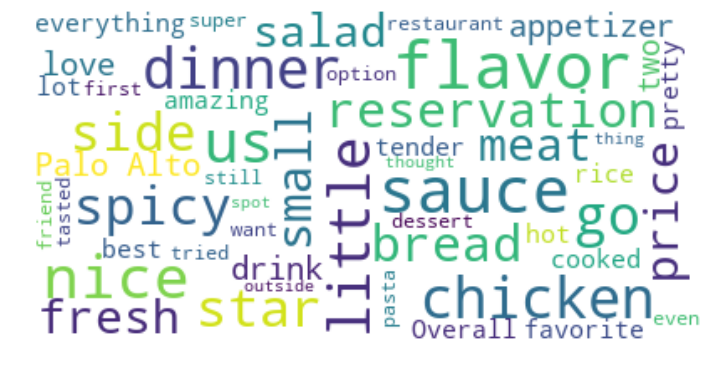

In [81]:
wordcloud_city(place='Palo Alto, CA',num_restaurant=25)


 Top restaurants found
----------------------------------------------------------------------------------------------------
Girl & the Goat, Quartino Ristorante, The Purple Pig, Mable’s Table, The Dearborn, Knife & Tine, Fusion 58, Summer House Santa Monica, Cafe Ba-Ba-Reeba!, Avec, Farmhouse Chicago, The Gage, Doc B’s Fresh Kitchen, Three Dots and a Dash, The Marq, Bavette’s Bar & Boeuf, Au Cheval, Beatrix Streeterville, Beacon Tavern, Burger Bar Chicago - South Loop, Farmhouse Chicago, The Gage, Doc B’s Fresh Kitchen, Three Dots and a Dash, The Marq, 

Gathering top reviews on Girl & the Goat now...
Reviews for Girl & the Goat gathered.
------------------------------------------------------------
Gathering top reviews on Quartino Ristorante now...
Reviews for Quartino Ristorante gathered.
------------------------------------------------------------
Gathering top reviews on The Purple Pig now...
Reviews for The Purple Pig gathered.
----------------------------------------------------

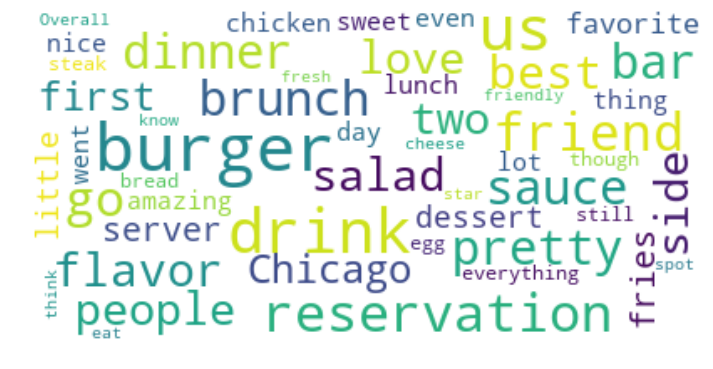

In [82]:
wordcloud_city(place='Chicago, IL',num_restaurant=25)